# cap 10 - Deep learning  for timeseries

## This chapter covers:

- Examples of machine learning tasks that involve timeseries data
- Understanding recurrent neural networks (RNNs)
- Applying RNNs to a temperature-forecasting example
- Advanced RNN usage patterns

A timeseries can be any data obtained via measurements at regular intervals, like the daily price of a stock, the hourly electricity consumption of a city, or the weekly sales of a store.

the most common timeseries-related task is forecasting: predicting what will happen next in a series.

other things you can do with timeseries:
- Classification—Assign one or more categorical labels to a timeseries. For instance, given the timeseries of the activity of a visitor on a website, classify whether the visitor is a bot or a human.
- Event detection—Identify the occurrence of a specific expected event within a continuous data stream. A particularly useful application is “hotword detection,” where a model monitors an audio stream and detects utterances like “Ok Google” or “Hey Alexa.”
- Anomaly detection—Detect anything unusual happening within a continuous datastream. Unusual activity on your corporate network? Might be an attacker. Unusual readings on a manufacturing line? Time for a human to go take a look. Anomaly detection is typically done via unsupervised learning, because you often don’t know what kind of anomaly you’re looking for, so you can’t train on specific anomaly examples.

In the context of deep learning, Fourier analysis (or the related Mel-frequency analysis) and other domain-specific representations can be useful as a form of feature engineering, a way to prepare data before training a model on it, to make the job of the model easier. However, we won’t cover these techniques in these pages; we will instead focus on the modeling part.

In this chapter, you’ll learn about recurrent neural networks (RNNs) and how to apply them to timeseries forecasting.

## 10.2 A temperature-forecasting example

predicting the temperature 24 hours in the future, given a timeseries of hourly measurements of quantities such as atmospheric pressure and humidity, recorded over the recent past by a set of sensors on the roof of a building.

We’ll work with a weather timeseries dataset recorded at the weather station at the Max Planck Institute for Biogeochemistry in Jena, Germany.1 In this dataset, 14 different quantities (such as temperature, pressure, humidity, wind direction, and so on) were recorded every 10 minutes over several years. The original data goes back to 2003, but the subset of the data we’ll download is limited to 2009–2016.

Listing 10.1 Inspecting the data of the Jena weather dataset

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

'wget' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.
'unzip' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
	data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

print(header)
print(len(lines))


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Now, convert all 420,551 lines of data into NumPy arrays: one array for the temperature (in degrees Celsius), and another one for the rest of the data—the features we will use to predict future temperatures. Note that we discard the “Date Time” column

In [3]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
	values = [float(x) for x in line.split(",")[1:]]
	#We store column 1 in the  “temperature” array.
	temperature[i] = values[1]
	#We store all columns (including the  temperature) in the “raw_data” array.
	raw_data[i, :] = values[:]

over time. On this plot, you can clearly see the yearly periodicity of temperature

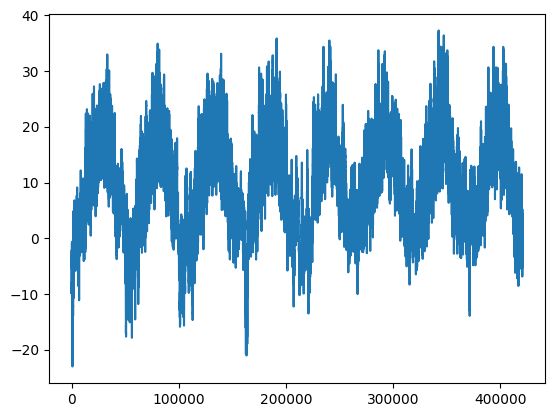

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

shows a more narrow plot of the first 10 days of temperature data. Because the data is recorded every 10 minutes, you get 24 × 6 = 144 data points per day.

## Temperature over the first 10 days of the dataset (oC)

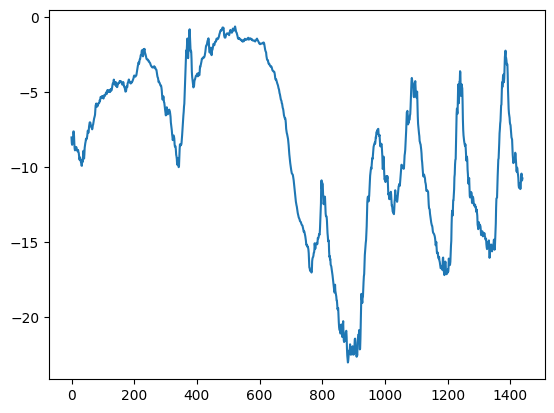

In [5]:
plt.plot(range(1440), temperature[:1440])

With our dataset, if you were trying to predict average temperature for the next month given a few months of past data, the problem would be easy, due to the reliable yearscale periodicity of the data. But looking at the data over a scale of days, the temperature looks a lot more chaotic. Is this timeseries predictable at a daily scale? Let’s find out.

In all our experiments, we’ll use the first 50% of the data for training, the following 25% for validation, and the last 25% for testing. When working with timeseries data, it’s important to use validation and test data that is more recent than the training data, because you’re trying to predict the future given the past, not the reverse, and your validation/test splits should reflect that. Some problems happen to be considerably simpler if you reverse the time axis!

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


## 10.2.1 Preparing the data

### The exact formulation of the problem will be as follows: given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?

We’ll normalize each timeseries independently so that they all take small values on a similar scale. We’re going to use the first 210,225 timesteps as training data, so we’ll compute the mean and standard deviation only on this fraction of the data.

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

#### Listing 10.7 Instantiating datasets for training, validation, and testing

In [8]:
import keras
sampling_rate = 6
sequence_length = 120
#The target for a sequence will be the temperature 24 hours after the end of the sequence
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
	sequence_length=sequence_length,
	shuffle=True,
	batch_size=batch_size,
	start_index=0,
	end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
	sequence_length=sequence_length,
	shuffle=True,
	batch_size=batch_size,
	start_index=num_train_samples,
	end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
	sequence_length=sequence_length,
	shuffle=True,
	batch_size=batch_size,
	start_index=num_train_samples + num_val_samples,
)

Each dataset yields a tuple (samples, targets), where samples is a batch of 256 samples, each containing 120 consecutive hours of input data, and targets is the corresponding array of 256 target temperatures.

Note that the samples are randomly shuffled, so two consecutive sequences in a batch (like samples[0] and samples[1]) aren’t necessarily temporally close.

In [9]:
for samples, targets in train_dataset:
	print("samples shape:", samples.shape)
	print("targets shape:", targets.shape)
	break


samples shape: (256, 120, 14)
targets shape: (256,)


Listing 10.9 Computing the common-sense baseline MAE

(common sense, non-machine learning baseline)

In [10]:
def evaluate_naive_method(dataset):
	total_abs_err = 0
	samples_seen = 0
	for samples, targets in dataset:
		preds = samples[:, -1, 1] * std[1] + mean[1]
		total_abs_err += np.sum(np.abs(preds - targets))
		samples_seen += samples.shape[0]
	return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


This common-sense baseline achieves a validation MAE of 2.44 degrees Celsius and a test MAE of 2.62 degrees Celsius. So if you always assume that the temperature 24 hours in the future will be the same as it is now, you will be off by two and a half degrees on average.

### 10.2.3 Let’s try a basic machine learning model

The following listing shows a fully connected model that starts by flattening the data and then runs it through two Dense layers. Note the lack of an activation function on the last Dense layer, which is typical for a regression problem. We use mean squared error (MSE) as the loss, rather than MAE, because unlike MAE, it’s smooth around zero, which is a useful property for gradient descent. We will monitor MAE by adding it as a metric in compile().

In [11]:
from keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
	keras.callbacks.ModelCheckpoint("jena_dense.keras",
									save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
	epochs=10,
	validation_data=val_dataset,
	callbacks=callbacks
)

model = keras.models.load_model("jena_dense.keras")
print("Test MAE: %.2f" % model.evaluate(test_dataset)[1])


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 15.6764 - mae: 3.0440 - val_loss: 11.4671 - val_mae: 2.6743
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 10.1089 - mae: 2.5037 - val_loss: 12.1150 - val_mae: 2.7628
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 9.2802 - mae: 2.3991 - val_loss: 11.3448 - val_mae: 2.6689
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 8.7504 - mae: 2.3280 - val_loss: 11.0404 - val_mae: 2.6349
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 8.3546 - mae: 2.2748 - val_loss: 11.7806 - val_mae: 2.7260
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 8.0795 - mae: 2.2341 - val_loss: 10.4256 - val_mae: 2.5552
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 7.8625 - mae: 2.2059 - val_loss: 10.9698 - val_mae: 2.6118
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 7.6449 - mae: 2.1771 - val_loss: 13.9553 - val_mae: 2.9721
Epoch 9/10
819/819 ━━━━━━━━━━━━

plotting the results:

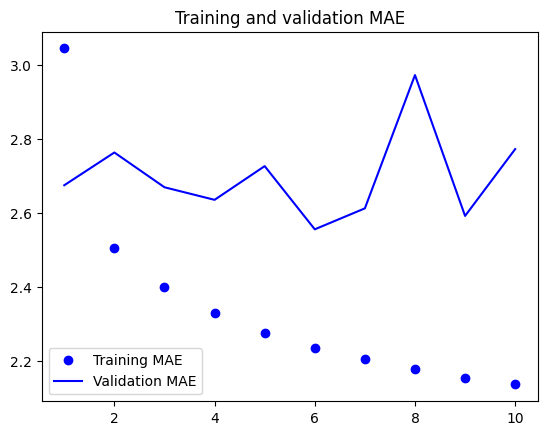

In [12]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()



### 10.2.4 Let’s try a 1D convolutional model

You can thus build 1D convnets, strictly analogous to 2D convnets. They’re a great fit for any sequence data that follows the translation invariance assumption (meaning that if you slide a window over the sequence, the content of the window should follow the same properties independently of the location of the window).

Let’s try one on our temperature-forecasting problem. We’ll pick an initial window length of 24, so that we look at 24 hours of data at a time (one cycle). As we downsample the sequences (via MaxPooling1D layers), we’ll reduce the window size accordingly:

In [13]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu") (inputs)
x = layers.MaxPool1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu") (inputs)
x = layers.MaxPool1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu") (inputs)
x = layers.MaxPool1D(2)(x)
outputs = layers.Dense(1) (x)
model = keras.Model(inputs, outputs)

callbacks = [
	keras.callbacks.ModelCheckpoint("jena_conv.keras",
									save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
	epochs=10,
	validation_data=val_dataset,
	callbacks=callbacks
)
model = keras.models.load_model("jena_conv.keras")
print("Test MAE: %.2f" % model.evaluate(test_dataset)[1])


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 90.0821 - mae: 7.6651 - val_loss: 66.8004 - val_mae: 6.7181
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 76.6779 - mae: 7.0939 - val_loss: 65.5875 - val_mae: 6.6642
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 76.3643 - mae: 7.0804 - val_loss: 65.8937 - val_mae: 6.6809
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 76.2997 - mae: 7.0774 - val_loss: 65.2630 - val_mae: 6.6488
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 76.2835 - mae: 7.0768 - val_loss: 65.8145 - val_mae: 6.6774
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 76.2772 - mae: 7.0767 - val_loss: 65.2878 - val_mae: 6.6506
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 76.2663 - mae: 7.0758 - val_loss: 65.2890 - val_mae: 6.6507
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 76.2652 - mae: 7.0760 - val_loss: 65.4917 - val_mae: 6.6613
Epoch 9/10
819/819 ━━━━━

We get the training and validation curves shown in figure 10.4. As it turns out, this model performs even worse than the densely connected one, only achieving a validation MAE of about 2.9 degrees, far from the common-sense baseline. What went wrong here? Two things:
- First, weather data doesn’t quite respect the translation invariance assumption. While the data does feature daily cycles, data from a morning follows different properties than data from an evening or from the middle of the night. Weather data is only translation-invariant for a very specific timescale.
- Second, order in our data matters—a lot. The recent past is far more informative for predicting the next day’s temperature than data from five days ago. A 1D convnet is not able to leverage this fact. In particular, our max pooling and global average pooling layers are largely destroying order information.

### 10.2.5 A first recurrent baseline

Neither the fully connected approach nor the convolutional approach did well, but that doesn’t mean machine learning isn’t applicable to this problem. The densely connected approach first flattened the timeseries, which removed the notion of time from the input data. The convolutional approach treated every segment of the data in the same way, even applying pooling, which destroyed order information.

There’s a family of neural network architectures designed specifically for this use case: recurrent neural networks. Among them, the Long Short Term Memory (LSTM) layer has long been very popular. We’ll see in a minute how these models work, but let’s start by giving the LSTM layer a try.

#### Listing 10.12 A simple LSTM-based model

#### We’ll use timeseries_dataset_from_array() to instantiate three datasets: one for training, one for validation, and one for testing.
We’ll use the following parameter values::
- sampling_rate = 6—Observations will be sampled at one data point per hour: we will only keep one data point out of 6.
- sequence_length = 120—Observations will go back 5 days (120 hours).
- delay = sampling_rate * (sequence_length + 24 - 1)—The target for a sequence will be the temperature 24 hours after the end of the sequence

Epoch 1/10


819/819 ━━━━━━━━━━━━━━━━━━━━ 31s 36ms/step - loss: 36.7442 - mae: 4.4101 - val_loss: 12.0269 - val_mae: 2.6595
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - loss: 10.7130 - mae: 2.5490 - val_loss: 10.4129 - val_mae: 2.4881
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - loss: 9.6913 - mae: 2.4356 - val_loss: 10.3503 - val_mae: 2.4800
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - loss: 9.3119 - mae: 2.3873 - val_loss: 10.3366 - val_mae: 2.4770
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - loss: 9.0393 - mae: 2.3494 - val_loss: 9.7501 - val_mae: 2.4181
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - loss: 8.8579 - mae: 2.3214 - val_loss: 9.9114 - val_mae: 2.4332
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - loss: 8.6984 - mae: 2.2961 - val_loss: 10.1668 - val_mae: 2.4609
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 8.5183 - mae: 2.2697 - val_loss: 9.8046 - val_mae: 2.4199
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 29s 

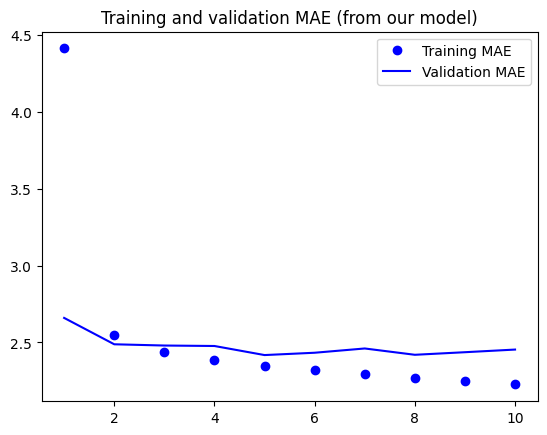

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
	keras.callbacks.ModelCheckpoint("jena_lstm.keras",
									save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
	epochs=10,
	validation_data=val_dataset,
	callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print("Test MAE: %.2f" % model.evaluate(test_dataset)[1])

#plotting the results:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE (from our model)")
plt.legend()
plt.show()





But why did the LSTM model perform markedly better than the densely connected one or the convnet? And how can we further refine the model? To answer this, let’s take a closer look at recurrent neural networks.

an RNN is a for loop that reuses quantities computed during the previous iteration of the loop, nothing more. Of course, there are many different RNNs fitting this definition that you could build—this example is one of the simplest RNN formulations. RNNs are characterized by their step function, such as the following function in this case (

output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)

NOTE: In this example, the final output is a rank-2 tensor of shape (timesteps, output_features), where each timestep is the output of the loop at time t. Each timestep t in the output tensor contains information about timesteps 0 to t in the input sequence—about the entire past. For this reason, in many cases, you don’t need this full sequence of outputs; you just need the last output (output_t at the end of the loop), because it already contains information about the entire sequence.

### 10.3.1 A recurrent layer in Keras

SimpleRNN processes batches of sequences This means it takes inputs of shape (batch_size, timesteps, input_features), rather than (timesteps, input_features). When specifying the shape argument of the initial Input(), note that you can set the timesteps entry to None, which enables your network to process sequences of arbitrary length.

In [16]:
# an RNN layer that can process sequences of any length:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16) (inputs)